# Subreddit Canada

/r/canada is a subreddit on reddit dedicated to discussion about all things Canada.  It contains a variety of content ranging from news articles to redditors memeing about how bad Tim Hortons is for the thousandth time.  The subreddit also has about 397000 subscribers and posts new content frequently.

The goal of this project is to predict whether a comment made in the /r/canada subreddit will have a positive score, where the score is equal to 1 or higher, or a negative score, where the score is lower than 1.  Features used to predict this include words that make up the comment and whether it's posted by a moderator or is gilded.

This dataset was obtained by running a MySQL query on a dataset containing all reddit comments made for May 2018.  The original dataset contained over 100 million entries, but was narrowed down to just the /r/canada subreddit for a more manageable size.

# Hypothesis

Comment content will be the main influence that affects the score of a comment being positive or negative.

## Set-up

We begin by setting up the environment that we will be working in.  We need packages such as pandas and numpy to manipulate our dataframe.  NLTK and spacy are needed to be able to process the text of the comments that we are analyzing.

In [47]:
# set up the environment to work in
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import re

# word counting
from collections import Counter

# spacy
import spacy
import plac
from spacy.attrs import ORTH
import io

# scikit learn, classifier to create the model
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AFKsi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We also have to load the natural language processing (NLP) module for english for spacy to be able to process text.

In [2]:
# load the english module for spacy
nlp = spacy.load('en_core_web_sm')

## Import the dataset

Next we import our dataset, "canada.csv" and give it a quick inspection.

In [3]:
# import csv file here
canada = pd.read_csv("canada.csv")
canada.head()

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class
0,Not really. The Republicans tend to run on to...,False,False,NaN,Yst,NaN,NaN,1526673110,t5_2qh68,t3_8kdzfm,t1_dz75u0z,0,1527675740,1,0,dz7c5sx,canada,NaN,NaN,NaN
1,"Yeah, keep telling yourself that. Like Paris o...",False,False,NaN,fhs,NaN,NaN,1527120669,t5_2qh68,t3_8lk8oz,t1_dzg6tni,0,1527883848,0,0,dzh3six,canada,NaN,NaN,NaN
2,I'm sorry about the bad news but no one will g...,False,False,NaN,0xDS,Canada,NaN,1525820610,t5_2qh68,t3_8hmhu9,t1_dyljtkl,0,1527242337,0,0,dyo3c08,canada,NaN,NaN,CAN
3,well peterson is another person i wish i'd nev...,False,False,NaN,4ofN,NaN,NaN,1527414551,t5_2qh68,t3_8megob,t1_dznegrf,0,1528014577,1,0,dzngf7t,canada,NaN,NaN,NaN
4,"Canada claimed to be a ""climate leader""? Don't...",False,False,NaN,G-42,NaN,NaN,1527721690,t5_2qh68,t3_8ncuol,t3_8ncuol,0,1528172545,1,0,dzumflr,canada,NaN,NaN,NaN


There are a significant number of columns that are empty as well as ones that do not pertain to our project.  Thus, we would be removing them to clean up the data later.

## Data Cleaning

The first step would be to remove any columns that I am sure that I won't need.  This makes the dataset significantly more readable and easier to use.

In [4]:
# remove a handful of columns
canada.drop("score_hidden", axis = 1, inplace = True)
canada.drop("archived", axis = 1, inplace = True)
canada.drop("name", axis = 1, inplace = True)
canada.drop("author_flair_text", axis = 1, inplace = True)
canada.drop("created_utc", axis = 1, inplace = True)
canada.drop("subreddit_id", axis = 1, inplace = True)
canada.drop("link_id", axis = 1, inplace = True)
canada.drop("parent_id", axis = 1, inplace = True)
canada.drop("retrieved_on", axis = 1, inplace = True)
canada.drop("id", axis = 1, inplace = True)
canada.drop("subreddit", axis = 1, inplace = True)
canada.drop("author_flair_css_class", axis = 1, inplace = True)
canada.drop("downs", axis = 1, inplace = True)
canada.drop("ups", axis = 1, inplace = True)

# inspect the dataset now
canada.head()

,body,author,score,controversiality,gilded,distinguished
0,Not really. The Republicans tend to run on to...,Yst,0,1,0,NaN
1,"Yeah, keep telling yourself that. Like Paris o...",fhs,0,0,0,NaN
2,I'm sorry about the bad news but no one will g...,0xDS,0,0,0,NaN
3,well peterson is another person i wish i'd nev...,4ofN,0,1,0,NaN
4,"Canada claimed to be a ""climate leader""? Don't...",G-42,0,1,0,NaN


Next, some data cleaning.  To begin with, I know that on reddit, sometimes, people post comments that they regret later on and these become "[deleted]".  The same can be said for the "[removed]" comment since these were removed by moderators but in both cases, they provide me with no real data.

Of course, these kinds of comments are pointless in the dataset so it would be good to remove them from it.

In [5]:
# create a list with the index of all comments that are [deleted] and [removed]
deletedCanada = canada.index[canada["body"] == "[deleted]"].tolist()
deletedCanada = canada.index[canada["body"] == "[removed]"].tolist()

# now delete all of these from the dataset
canada.drop(canada.index[deletedCanada], inplace = True)

# and now we check to make sure this was done correctly for [deleted]
"[deleted]" in canada["body"]

False

In [6]:
# and check for [removed] as well
"[removed]" in canada["body"]

False

Now, onto some of the individual columns.  "distinguished" is one of the columns that we are interested in so we begin by checking to see what values are in it.

In [7]:
# check what values are in the distinguished column
canada["distinguished"].unique()

array([nan, 'moderator'], dtype=object)

Since the "distinguished" variables only contains 2 levels, I can fill the NaN values as 0 and dummy code the "moderator" value as 1.  This is necessary as statistical models can't really process strings and need numbers instead.

In [8]:
# convert all values in the "distinguished" column
canada["distinguished"].fillna(0, inplace = True)

# convert the "moderator" values
canada.distinguished[canada.distinguished == "moderator"] = 1

# check to see if this is done correctly
1 in canada["distinguished"]

C:\Users\AFKsi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


True

To make it easier to remember as well, I rename the column to isModerator.

In [9]:
canada.rename(columns={'distinguished': 'isModerator'}, inplace=True)
canada.head()

,body,author,score,controversiality,gilded,isModerator
0,Not really. The Republicans tend to run on to...,Yst,0,1,0,0
1,"Yeah, keep telling yourself that. Like Paris o...",fhs,0,0,0,0
2,I'm sorry about the bad news but no one will g...,0xDS,0,0,0,0
3,well peterson is another person i wish i'd nev...,4ofN,0,1,0,0
4,"Canada claimed to be a ""climate leader""? Don't...",G-42,0,1,0,0


We create a new column to label the data.  Here, a score of 1 or higher would be a positive score while a score of 0 or lower would indicate a negative score.  Thus, the labels will become 1 for a positive range and 0 for a negative range of scores.

In [10]:
# add a new column and fill it with arbitrary data
canada["label"] = 0

Find all the scores that are equal or greater than 1 and label them 1 and all scores that are lower than 1 as 0.

In [11]:
# find and label the scores
canada.loc[canada["score"] > 1, "label"] = 1
canada.loc[canada["score"] < 1, "label"] = 0

In [12]:
# check to make sure the code ran correctly
canada["label"].unique()

array([0, 1], dtype=int64)

Missing data will impact our results and may even throw us an error later on when we try to model our data so we check for it now.

In [13]:
# missing data check
canada.apply(lambda x: sum(x.isnull()), axis=0)

body                2
author              0
score               0
controversiality    0
gilded              0
isModerator         0
label               0
dtype: int64

So there appears to be some missing data in 2 "body" sections.  Now we have to find them and investigate whether it is worthwhile to drop them.

In [14]:
# find the sections where "body" has null data
nullData = canada[canada.isnull().any(axis = 1)]
nullData.head()

,body,author,score,controversiality,gilded,isModerator,label
18389,NaN,Un_Conquered,1,0,0,0,0
137683,NaN,hagunenon,-5,1,0,0,0


Now that we've identified rows 18389 and 137683 as the one's with missing data, we can remove them.  In this case, we have to remove them as missing data in the body section is particularly useless to us.

In [15]:
# remove the rows from the dataset
canada = canada[canada.body.notnull()]

And we check once more to make sure that the missing data is gone.

In [16]:
# missing data check again
canada.apply(lambda x: sum(x.isnull()), axis = 0)

body                0
author              0
score               0
controversiality    0
gilded              0
isModerator         0
label               0
dtype: int64

We also need to convert all the comments into strings so that spacy can process them.

In [17]:
# convert all comments into strings so that they can be processed
canada.body.apply(str)

0         Not really.  The Republicans tend to run on to...
1         Yeah, keep telling yourself that. Like Paris o...
2         I'm sorry about the bad news but no one will g...
3         well peterson is another person i wish i'd nev...
4         Canada claimed to be a "climate leader"? Don't...
5         Because we're forced to translate everything i...
6         Does exploiting others for profit count as doi...
7                      That's a good thing to hear I think.
8         Cool, that's not the plan.  But you're not pay...
9         It says they are going to use deficit spending...
10        That is also obviously not okay, but it is als...
11        &gt; Interesting, I know someone who was refer...
12        &gt; The only thing ridiculous is your inabili...
13                                      Horton wears a poo.
14        but going from voting Liberals, youve went to ...
15        I am not addicted to drugs, but I see the effe...
16                 They have to go home 

The last thing we need to do is to reindex the dataset to fit the 208605 rows instead of ending at 213480.

In [18]:
# reset the index
canada = canada.reset_index(drop = True)
canada.head()

,body,author,score,controversiality,gilded,isModerator,label
0,Not really. The Republicans tend to run on to...,Yst,0,1,0,0,0
1,"Yeah, keep telling yourself that. Like Paris o...",fhs,0,0,0,0,0
2,I'm sorry about the bad news but no one will g...,0xDS,0,0,0,0,0
3,well peterson is another person i wish i'd nev...,4ofN,0,1,0,0,0
4,"Canada claimed to be a ""climate leader""? Don't...",G-42,0,1,0,0,0


# Splitting the dataset

The dataset needs to be split into a training and test dataset in order to fit the model.  The training dataset is used to initially train the model whilst the test set is used to check how well the model generalizes to data that it doesn't know the answer to.

First, the data is split into 2 random, but reproducible, sets.

In [19]:
# split the dataset into training and test sets
trainCanada = canada.sample(frac = 0.8,random_state = 200)
testCanada = canada.drop(trainCanada.index)

# check to see trainCanada was set up correctly
len(trainCanada)

166882

In [20]:
# and check the same for testCanada
len(testCanada)

41721

In [21]:
# view a little bit of trainCanada
trainCanada.head()

,body,author,score,controversiality,gilded,isModerator,label
182169,"In a way, your last sentence is pretty much th...",Sexploits,5,0,0,0,1
36267,Good. The political risk being created by BC w...,1dererLives,3,1,0,0,1
45507,That... doesn't look bad at all. I was expecti...,DWillows,6,0,0,0,1
154491,I used a mouse. Does it not work on mobile?,NoveltyName,1,0,0,0,0
24184,McDonald's coffee is actually better,choss,2,0,0,0,1


In [22]:
# and view a little of testCanada too
testCanada.head()

,body,author,score,controversiality,gilded,isModerator,label
0,Not really. The Republicans tend to run on to...,Yst,0,1,0,0,0
4,"Canada claimed to be a ""climate leader""? Don't...",G-42,0,1,0,0,0
9,It says they are going to use deficit spending...,MrT6,0,1,0,0,0
13,Horton wears a poo.,Tooq,0,0,0,0,0
23,None of that matters when a parent is trying t...,jtbc,0,1,0,0,0


# Further processing

The "body" of the dataset needs to be further processed so that we can find out the more common words used.

First, we have to set some limitations using stop words from NLTK.  Stop words are very common words that would be present in the vast majority of text and thus, would provide no statistical value to us.

In [30]:
# load stop words
stopWords = stopwords.words("english")

# print a few examples of stop words
print(stopWords[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


Next, we need to process the comments.  "Hello" and "hello" are the same word for our purposes, but the script would seperate them as 2 seperate entities, influencing what information we can elucidate from the model.  The above stop words also need to be applied to the data.  The following function neatly wraps up all the above that needs to be done so that it can be easily iterated across the whole dataset(s).

In [31]:
# function to convert comments into lowercase and remove common stop words
def processComments(comment):
    comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not stopWords or (stopWords and lemma not in stopWords):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

Finally, we can apply our processing to the data.  This will "lemmatize" it or sort words by grouping inflected or variant forms of the same word.

In [33]:
# lemmatize trainCanada
lemmatizedTrainCanada = trainCanada.body.apply(processComments)

In [34]:
# take a peek at what we created
lemmatizedTrainCanada.head()

130774    list lie get really quite long . still particu...
55871     surprised . -PRON- champion woman 's right cel...
112660    -PRON- . -PRON- suppose teach certain moral pe...
121037                              -PRON- one say -PRON- .
170669                                 forget " eh " , eh ?
Name: body, dtype: object

In [35]:
# lemmatize testCanada
lemmatizedTestCanada = testCanada.body.apply(processComments)

In [36]:
# take a peek at what was created
lemmatizedTestCanada.head()

0     really . republican tend run token issue fearm...
4     canada claim " climate leader " ? -PRON- produ...
9     -PRON- say -PRON- go use deficit spending revi...
13                                    horton wear poo .
23    none matter parent try decide whether get -PRO...
Name: body, dtype: object

Now we can construct dataframes out of the newly processed data for ease of use later.

In [172]:
# assign lemmatizedTrainCanada to newTrainCanada
newTrainCanada = lemmatizedTrainCanada

In [173]:
# convert into a dataframe
newTrainCanada = pd.DataFrame(newTrainCanada, columns = ["body"])

In [174]:
# taking a look at the new dataframe
newTrainCanada.head()

,body
130774,list lie get really quite long . still particu...
55871,surprised . -PRON- champion woman 's right cel...
112660,-PRON- . -PRON- suppose teach certain moral pe...
121037,-PRON- one say -PRON- .
170669,"forget "" eh "" , eh ?"


In [175]:
# repeat for lemmatizedTestCanada
newTestCanada = lemmatizedTestCanada
newTestCanada = pd.DataFrame(newTestCanada, columns = ["body"])
newTestCanada.head()

,body
0,really . republican tend run token issue fearm...
4,"canada claim "" climate leader "" ? -PRON- produ..."
9,-PRON- say -PRON- go use deficit spending revi...
13,horton wear poo .
23,none matter parent try decide whether get -PRO...


## Exploration

Now that we have finished cleaning and processing our dataset, we can do exploration to get a better idea of what's in it.

We can take a look at the highest and lowest scoring comments.

In [52]:
# highest scoring comment
canada.loc[canada["score"].idxmax()]

body                We as citizens can’t do a lot about Trump’s st...
author                                             Shakethecrimestick
score                                                            5292
controversiality                                                    0
gilded                                                              1
isModerator                                                         0
label                                                               1
Name: 201740, dtype: object

In [53]:
# lowest scoring comment
canada.loc[canada["score"].idxmin()]

body                &gt; The discourse is complete shit\n\nOkay, w...
author                                                VirtueSignal247
score                                                            -222
controversiality                                                    0
gilded                                                              0
isModerator                                                         0
label                                                               0
Name: 129680, dtype: object

Also the most gilded comment.

In [54]:
# most gilded comment
canada.loc[canada["gilded"].idxmax()]

body                Tomorrow is Remembrance Day in The Netherlands...
author                                                        mdslktr
score                                                            1157
controversiality                                                    0
gilded                                                              4
isModerator                                                         0
label                                                               1
Name: 62405, dtype: object

We can see that our scores cover a large range from -222 to 5292.  Interestingly, the most gilded comment also happens to not have the highest score.  This gives an indication that the amount of times a comment is gilded may not play a role in how highly scored a comment is.

We can plot a bar chart to get an idea of the distribution of our data.  Are there more positive comments or more negative comments?

Text(0,0.5,'Frequency')

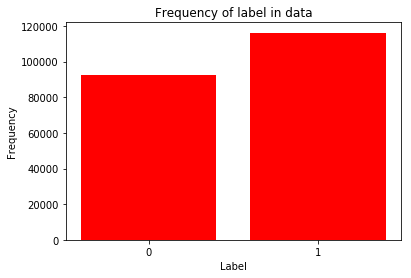

In [38]:
# number of rows with a label of 1
counter1 = 0
for item in canada["label"]:
    if item == 1:
        counter1 +=1

# number of rows with a label of 0
counter0 = len(canada) - counter1
        
# dictionary of values
dictionary = {"0":counter0, "1":counter1}

# plot the bar chart
plt.bar(range(len(dictionary)), dictionary.values(), align='center', color = "red")
plt.xticks(range(len(dictionary)), dictionary.keys())

# labelling...
plt.title("Frequency of label in data")
plt.xlabel("Label")
plt.ylabel("Frequency")

The majority of our comments are in a positive range although the negative range comments don't lag behind too much.  So much for the idea of Canadians being nice and upvoting everything.

We can also take a closer look at how gilding a comment influences it's score.

Text(0,0.5,'Comment score')

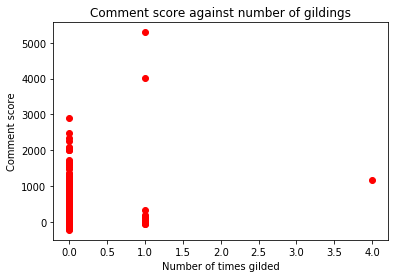

In [39]:
# plot of gilded comments vs their scores
plt.scatter(x = canada["gilded"], y = canada["score"], color = "red")

# labelling
plt.title("Comment score against number of gildings")
plt.xlabel("Number of times gilded")
plt.ylabel("Comment score")

It's worth noting from this plot that there is no correlation between comment score and the number of times it has been gilded.  Note how the highest rated comment was only gilded once but a lower comment was gilded 4 times.  This indicates that our "gilded" variable in the dataset may not be statistically significant and worth dropping.

Another plot to show how a comment posted by a moderator might influence it's score.

Text(0,0.5,'Comment score')

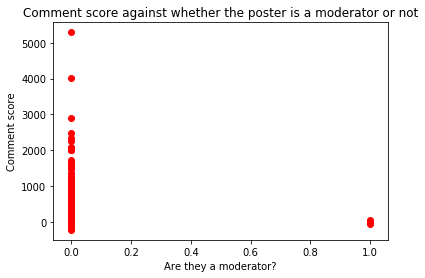

In [41]:
# set the column as an integer so it can be used by plotly
canada["isModerator"].astype(int)

# scatter plot for "isModerator"
plt.scatter(x = canada["isModerator"], y = canada["score"], color = "red")

# labelling...
plt.title("Comment score against whether the poster is a moderator or not")
plt.xlabel("Are they a moderator?")
plt.ylabel("Comment score")

We can see from our visualization that moderator comments result in much lower scores.  Apparently, no one likes moderators.

Text(0,0.5,'Comment score')

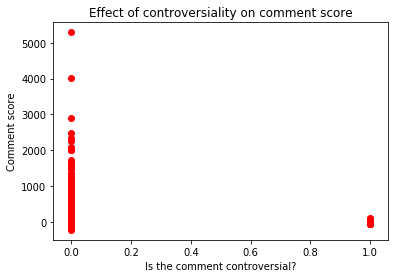

In [42]:
# scatter plot for controversiality
plt.scatter(x = canada["controversiality"], y = canada["score"], color = "red")

# labelling...
plt.title("Effect of controversiality on comment score")
plt.xlabel("Is the comment controversial?")
plt.ylabel("Comment score")

Having a controversial comment also lowers the comment's score.  Purely speculative, but with the the shape of isModerator and controversiality so similar, the most controversial scores may actually come from moderators.

Finally, we might look at the distribution of the scores.

C:\Users\AFKsi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

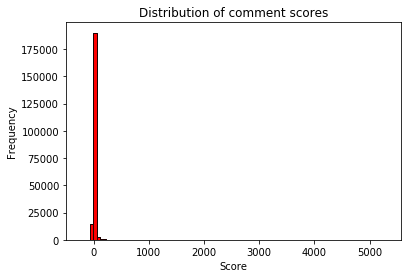

In [51]:
# matplotlib base
plt.hist(canada["score"], color = 'red', edgecolor = "black", bins = 100)

# seaborn addition
sns.distplot(canada["score"], hist = True, kde = False, bins = 100, color = 'red', hist_kws={'edgecolor':'black'})

# labelling
plt.title("Distribution of comment scores")
plt.xlabel("Score")
plt.ylabel("Frequency")

While it's hard to make out, our distribution appears to be a right-skewed one.  Remember that we have comment scores going all the way to 5292 and those are heavily skewing the histogram to the right.  Of course, given how few there are, considering we practically can't see the bars for the further numbers, those could be considered outliers and might be discounted from the idea that the data is heavily right skewed and in fact, may be a lot closer to normal than it appears here.

## Further processing

Now that we have a set of training data that has been converted to lower case and had stop words removed, we can find the most common words in it.  It stands to reason that the more commonly used words are words that are likely to influence the score of a comment more heavily.  

To do so, we use the "counter" package to find the 100 most common elements in comments.

In [176]:
# find the most common elements in comments
mostCommon = Counter(" ".join(lemmatizedTrainCanada).split()).most_common(100)

# view the list
mostCommon

[('-PRON-', 505276),
 ('.', 362781),
 (',', 216585),
 ('?', 53701),
 ('"', 48983),
 ('-', 42036),
 ('people', 33322),
 ('would', 30843),
 ('get', 28454),
 ('*', 26841),
 (')', 25229),
 ('&', 24449),
 ('like', 24061),
 ('go', 23623),
 ('make', 21818),
 ('say', 21165),
 ('/', 20319),
 ('think', 18667),
 ('one', 18542),
 ('[', 18067),
 ('good', 17091),
 ('(', 17059),
 (';', 16419),
 ('canada', 16359),
 ('know', 13781),
 ('want', 13616),
 ('right', 13492),
 (']', 13441),
 ('!', 13204),
 ("'s", 12704),
 ('even', 12665),
 ('time', 12479),
 ('...', 12229),
 ('year', 12188),
 ('thing', 12165),
 ('work', 12128),
 ('gt', 12102),
 ('see', 11841),
 ('government', 11757),
 ('need', 11416),
 ('take', 11046),
 ('pay', 10907),
 ('use', 10794),
 ('also', 10474),
 ('canadian', 10434),
 (':', 10241),
 ('way', 9742),
 ('tax', 9545),
 ('much', 9425),
 ('could', 9101),
 ('well', 8844),
 ('delete', 8679),
 ('really', 8676),
 ("'", 8656),
 ('mean', 8606),
 ('country', 8457),
 ('come', 8123),
 ('point', 8094),

We can see that there are a lot of words and punctuation.  "-PRON-", pronoun, is an especially large number.  However, it is worth noting that punctuation and pronouns are very common elements in the english language, meaning it would tell us almost nothing in the grand sceheme of things.  Thus, it would be worthwhile to drop them.

In [177]:
# convert the list to a dataframe
mostCommonDF = pd.DataFrame(mostCommon, columns = ["word", "number"])
mostCommonDF.head()

,word,number
0,-PRON-,505276
1,.,362781
2,",",216585
3,?,53701
4,"""",48983


In [178]:
# list of indexes of unnecssary textual elements
removal = [0,1,2,3,4,5,9,10,11,16,19,21,22,27,28,29,32,45,53,58,68,73]

# remove those elements
mostCommonDF = mostCommonDF.drop(removal)

# take a look at what was created
mostCommonDF.head()

,word,number
6,people,33322
7,would,30843
8,get,28454
12,like,24061
13,go,23623


In [179]:
# reset the index
mostCommonDF.reset_index()

,index,word,number
0,6,people,33322
1,7,would,30843
2,8,get,28454
3,12,like,24061
4,13,go,23623
5,14,make,21818
6,15,say,21165
7,17,think,18667
8,18,one,18542
9,20,good,17091


# Process newTrainCanada

Now that we have a a set of the most common words in comments for /r/canada, we can further refine our initial dataset to include a number of binary columns, that is to say, columns that indicate the presence or absence of our common words.  We use these as features to train our model on later.

In [180]:
# list of all common words
commonWords = []

# add to the list
for item in mostCommonDF["word"]:
    if item not in commonWords:
        commonWords.append(item)

# view our list
commonWords

['people',
 'would',
 'get',
 'like',
 'go',
 'make',
 'say',
 'think',
 'one',
 'good',
 'canada',
 'know',
 'want',
 'right',
 'even',
 'time',
 'year',
 'thing',
 'work',
 'gt',
 'see',
 'government',
 'need',
 'take',
 'pay',
 'use',
 'also',
 'canadian',
 'way',
 'tax',
 'much',
 'could',
 'well',
 'delete',
 'really',
 'mean',
 'country',
 'come',
 'point',
 'give',
 'still',
 'money',
 'look',
 'try',
 'may',
 'bad',
 'actually',
 'live',
 'job',
 'someone',
 'many',
 'vote',
 'lot',
 'something',
 'issue',
 'sure',
 'back',
 'party',
 'never',
 'law',
 'remove',
 'cost',
 'find',
 'high',
 'every',
 'man',
 'happen',
 'seem',
 'fuck',
 'day',
 'problem',
 'call',
 'change',
 'tell',
 'anything',
 'post',
 'though',
 'talk']

In [181]:
# initialize new columns
for item in commonWords:
    newTrainCanada[item] = 0

# view the dataset
newTrainCanada.head()

,body,people,would,get,like,go,make,say,think,one,...,fuck,day,problem,call,change,tell,anything,post,though,talk
130774,list lie get really quite long . still particu...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55871,surprised . -PRON- champion woman 's right cel...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112660,-PRON- . -PRON- suppose teach certain moral pe...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121037,-PRON- one say -PRON- .,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
170669,"forget "" eh "" , eh ?",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We also want to include a few other columns for each comment.  Thankfully, we preserved the index of the original dataset so it becomes a simple case of merging our columns of interest from the originial dataset with the newTrainCanada set by index.

In [182]:
# merge our datasets by index
newTrainCanada = pd.merge(newTrainCanada, trainCanada[["score", "label", "isModerator"]], 
                          left_index = True, right_index = True)

# now view our dataset
newTrainCanada.head()

,body,people,would,get,like,go,make,say,think,one,...,call,change,tell,anything,post,though,talk,score,label,isModerator
130774,list lie get really quite long . still particu...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50,1,0
55871,surprised . -PRON- champion woman 's right cel...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,15,1,0
112660,-PRON- . -PRON- suppose teach certain moral pe...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,1,0
121037,-PRON- one say -PRON- .,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,1,0
170669,"forget "" eh "" , eh ?",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0


Now that we've done that, we want to set the values under each of the word columns.  It would be pointless if every single value was 0 since that would tell us absolutely nothing.  To do so, we write a function to automate this process.

In [183]:
# function to set the labels under each common word column
# we definitely want to use this function again later on
def setColumns(df, word):
    newList = []
    for line in df["body"]:
        if word in line:
            newList.append(1)
        else:
            newList.append(0)
    df[word] = newList

And then iterate it across the whole dataset.

In [184]:
# iterate the function across the whole dataset
for item in commonWords:
    setColumns(newTrainCanada, item)

# view the dataset
newTrainCanada.head()

,body,people,would,get,like,go,make,say,think,one,...,call,change,tell,anything,post,though,talk,score,label,isModerator
130774,list lie get really quite long . still particu...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,50,1,0
55871,surprised . -PRON- champion woman 's right cel...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,15,1,0
112660,-PRON- . -PRON- suppose teach certain moral pe...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,1,0
121037,-PRON- one say -PRON- .,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,9,1,0
170669,"forget "" eh "" , eh ?",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0


# Process newTestCanada

We have to repeat this process for newTestCanada so that we are able to test the model on a similar dataset after training.

In [185]:
# initialize the columns again
for item in commonWords:
    newTestCanada[item] = 0

# view the set
newTestCanada.head()

,body,people,would,get,like,go,make,say,think,one,...,fuck,day,problem,call,change,tell,anything,post,though,talk
0,really . republican tend run token issue fearm...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"canada claim "" climate leader "" ? -PRON- produ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,-PRON- say -PRON- go use deficit spending revi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,horton wear poo .,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,none matter parent try decide whether get -PRO...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
# once again, add the additional columns of interest to newTestCanada
newTestCanada = pd.merge(newTestCanada, testCanada[["score", "label", "isModerator"]], left_index = True, right_index = True)

# view the dataset
newTestCanada.head()

,body,people,would,get,like,go,make,say,think,one,...,call,change,tell,anything,post,though,talk,score,label,isModerator
0,really . republican tend run token issue fearm...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"canada claim "" climate leader "" ? -PRON- produ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,-PRON- say -PRON- go use deficit spending revi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,horton wear poo .,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,none matter parent try decide whether get -PRO...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
# iterate the setColumns function across the whole dataset
for item in commonWords:
    setColumns(newTestCanada, item)

# view the dataset
newTestCanada.head()

,body,people,would,get,like,go,make,say,think,one,...,call,change,tell,anything,post,though,talk,score,label,isModerator
0,really . republican tend run token issue fearm...,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,"canada claim "" climate leader "" ? -PRON- produ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,-PRON- say -PRON- go use deficit spending revi...,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
13,horton wear poo .,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,none matter parent try decide whether get -PRO...,0,0,1,0,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0


# Random Forest Modelling

We construct a Random Forest Classifier for our model.  Firstly, we have to split our training data into a set of features that the model will be trained on and a set of "answers" that the model can check its training on.

In [188]:
# list features we are training the model on
trainFeaturesList = commonWords

# add in "isModerator" since it'll be missing
trainFeaturesList.append("isModerator")

In [189]:
# create the training set
trainFeatures = newTrainCanada[trainFeaturesList]
trainFeatures.head()

,people,would,get,like,go,make,say,think,one,good,...,day,problem,call,change,tell,anything,post,though,talk,isModerator
130774,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
55871,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121037,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
170669,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [191]:
# answer key to the training set
trainLabel = newTrainCanada["label"]

# view the set
trainLabel.head()

130774    1
55871     1
112660    1
121037    1
170669    1
Name: label, dtype: int64

Now we can run the trainFeatures and trainScore through a random forest regression.  We initialize a model with 128 trees, a random state of 42 and then set the model to show us the progress of the model construction.  

128 trees was chosen because while a larger number of trees would yield a more accurate model, the trade off is a significantly longer time is needed to construct the model.

The random state of 42 is entirely arbitrary here and could just as easily have been excluded or set to 99.

Verbose is set to a random number larger than 1 to allow us to follow the model construction progress.

In [192]:
# initialize a random forest regression with 128 trees
clf = RandomForestClassifier(n_estimators = 128, random_state = 42, verbose = 3)

We can train the model using the "trainFeatures" and "trainScore" sets that we have created.  This will take a while due to the sheer number of trees being created for this model.

In [193]:
# train the model on the training features and scores
clf.fit(trainFeatures, trainLabel)

building tree 1 of 128


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 128


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 128
building tree 4 of 128
building tree 5 of 128
building tree 6 of 128
building tree 7 of 128
building tree 8 of 128
building tree 9 of 128
building tree 10 of 128
building tree 11 of 128
building tree 12 of 128
building tree 13 of 128
building tree 14 of 128
building tree 15 of 128
building tree 16 of 128
building tree 17 of 128
building tree 18 of 128
building tree 19 of 128
building tree 20 of 128
building tree 21 of 128
building tree 22 of 128
building tree 23 of 128
building tree 24 of 128
building tree 25 of 128
building tree 26 of 128
building tree 27 of 128
building tree 28 of 128
building tree 29 of 128
building tree 30 of 128
building tree 31 of 128
building tree 32 of 128
building tree 33 of 128
building tree 34 of 128
building tree 35 of 128
building tree 36 of 128
building tree 37 of 128
building tree 38 of 128
building tree 39 of 128
building tree 40 of 128
building tree 41 of 128
building tree 42 of 128
building tree 43 of 128
building tree 44 of 128

[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:   49.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=1,
            oob_score=False, random_state=42, verbose=3, warm_start=False)

# Testing the model

Test the model to see how accurate it is.  First, we would need to format the test features and score in a similar manner to the set of training data.

In [194]:
# create a list of all the labels similar to trainFeatures
testFeaturesList = trainFeaturesList

# construct the dataframe to fit the testing data
testFeatures = newTestCanada[testFeaturesList]

# view testFeatures
testFeatures.head()

,people,would,get,like,go,make,say,think,one,good,...,day,problem,call,change,tell,anything,post,though,talk,isModerator
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,1,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [115]:
# select the scores of the test set
testLabel = newTestCanada[["label"]]

Now we can run our model on the test set and have it make predictions.  Amusingly, compared to making the model, this takes practically no time at all.

In [195]:
# test the regression
predictions = clf.predict(testFeatures)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    1.6s finished


# Evaluation

Now we can evaluate our model to see how accurate it is as well as which features are actually useful to the model.  First, we construct a confusion matrix.

In [227]:
# confusion matrix for clf
pd.crosstab(newTestCanada['label'], predictions, rownames = ['Actual Label'], colnames=['Predicted Label'])

Predicted Label,0,1
Actual Label,,
0,4953,12569
1,4136,16514


Then with the help of the confusion matrix, we can calculate out the accuracy of the model by (TN+TP)/(TN+TP+FN+FP).

In [200]:
# accuracy of the model (TN+TP)/(TN+TP+FN+FP)
Accuracy = (4953+16514)/(4953+12569+4136+16514)

# accuracy as a percentage
print("Accuracy:", round(Accuracy*100, 2), "%")

Accuracy: 56.24 %


So overall, 56.24% of the time, our model accurately predicts that a comment will be either positive or negatively scored.  

We can also check and plot the feature importances in the model.  Here, we look at the top 30 most important features.

<Figure size 1080x1080 with 0 Axes>

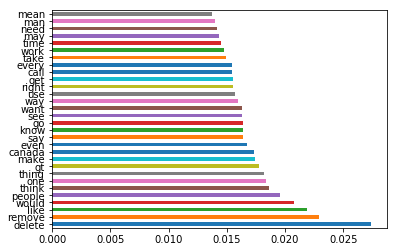

<Figure size 1080x1080 with 0 Axes>

In [215]:
# save the feature importances as a dataframe for plotting
featureImportance = pd.Series(clf.feature_importances_, index = testFeaturesList)

# plot a graph of the top 30 features and how important they are in comparison to one another
featureImportance.nlargest(30).plot(kind = "barh")
plt.figure(figsize=(15, 15))

# labelling...
plt.title("Feature Importance")
plt.xlabel("Degree of importance")
plt.ylabel("Feature")

We can also see the complete featureImportance itself for a better picture.

In [217]:
# view the dataframe
featureImportance

people         0.019565
would          0.020765
get            0.015517
like           0.021855
go             0.016370
make           0.017430
say            0.016440
think          0.018673
one            0.018358
good           0.012233
canada         0.017357
know           0.016422
want           0.016289
right          0.015562
even           0.016758
time           0.014531
year           0.010264
thing          0.018231
work           0.014772
gt             0.017772
see            0.016341
government     0.010144
need           0.014186
take           0.014926
pay            0.011583
use            0.015749
also           0.012671
canadian       0.010563
way            0.016009
tax            0.010638
                 ...   
someone        0.007782
many           0.006811
vote           0.010242
lot            0.010600
something      0.007424
issue          0.009355
sure           0.012799
back           0.011317
party          0.006781
never          0.010363
law            0

# Conclusions

Overall, our model classifies our comments correctly a little more than half the time. Comment content ended up the bigger influence on whether a comment received a positive or negative comment.  Indeed, the status of a poster being a moderator or not had an extremely small importance value of 0.003877. 

It's worth noting from the feature importance frame that most features weigh a very small amount, usually somewhere between 0.01 and 0.04.  However, there are also a number of features, 22 to be exact, that score lower than 0.01 and if wanted to try to improve the accuracy of our model, it might be worthwhile dropping those features from consideration as they can quietly skew the model to an inaccurate classification.

Another thing worth exploring would have been to count the number of times a word appears in a comment and have that appear as data (e.g. if "canadian" appears 4 times then we would record it as 4 instead of 1).  This might have led to a more accurate model as well.

In the end, predicting the whether a comment will receive a positive or negative score may not be easy to do using the comment contents.  Even in the top 30 features, the majority of words in them were common words used in the english language and again, it's worth noting that all the feature importances were very small.